# Causal Inference using DiD/DDD

#### This notebook performs a Multinomial Logistic Regression and Difference-in-Differences (DiD) analysis to estimate the impact of DEI policy rollbacks on Facebook comment sentiment (stance and purchase intention).

## 1. Imports and Configuration

In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.stats.mediation import Mediation
from tqdm import tqdm 

# Configuration
DATA_FILE = "../../data/derived/comments_with_sentiment.csv"
DATA_DIR  = "../../data/derived"
TABLES_DIR = "../../results/tables/causal"
FIGURES_DIR = "../../results/figures/causal"

TREATED_COMPANIES = ['Google', 'Target']
EVENT_WINDOW_PRE = -15  # Days before announcement
EVENT_WINDOW_POST = 30  # Days after announcement
REFERENCE_DAY = -1      # Reference day for event study

STANCE_COL = 'gpt4o_pred_stance_label'
PI_COL = 'gpt4o_pred_pi_label'

# Define DEI Cutoff Dates (Announcement Dates)
DEI_CUTOFF_DATES = {
    'Costco': datetime(2025, 1, 23),
    'Delta': datetime(2025, 2, 4),
    'Google': datetime(2025, 2, 5),
    'Target': datetime(2025, 1, 24),
}

## 2. Helper Functions

In [2]:
def create_output_dirs():
    os.makedirs(TABLES_DIR, exist_ok=True)
    os.makedirs(FIGURES_DIR, exist_ok=True)

def plot_parallel_trends(df, var, label, filename):
    # pick only the comments you've already flagged as pre-event
    tmp = df[
        (df['before_DEI'] == 1)
        & (df['rel_day'].between(EVENT_WINDOW_PRE, -1))
    ].copy()

    # collapse to the post‐level
    post_avg = (
        tmp
        .groupby([
            'company_name',
            'post_date',
            'Treated_Company_Flag',
            'rel_day'
        ])[var]
        .mean()
        .reset_index()
    )

    # then average across posts by group & day
    daily = (
        post_avg
        .groupby(['Treated_Company_Flag', 'rel_day'])[var]
        .mean()
        .reset_index()
    )
    daily['Group'] = daily['Treated_Company_Flag'].map({0: 'Control', 1: 'Treated'})

    # plot
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=daily,
        x='rel_day',
        y=var,
        hue='Group',
        marker='o'
    )
    plt.title(f'Parallel Trends (Pre-event): {label}')
    plt.xlabel('Days Relative to Announcement')
    plt.ylabel(label)
    plt.xlim(EVENT_WINDOW_PRE, 0)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, filename), dpi=300)
    plt.show()


def plot_event_study(df, var, label, filename):
    # pick only the comments you've already flagged as pre-event for the pre-period
    df_pre_period = df[
        (df['before_DEI'] == 1) &
        (df['rel_day'] < 0)  # df is df_did, already filtered to pre-event days within the window
    ].copy()
    # keep every post‐level day in the full window for the post-period
    df_post_period = df[
        df['rel_day'] >= 0  # df is df_did, already filtered to post-event days within the window
    ].copy()
    tmp = pd.concat([df_pre_period, df_post_period], ignore_index=True)

    # collapse and average just like above
    post_avg = (
        tmp
        .groupby([
            'company_name',
            'post_date',
            'Treated_Company_Flag',
            'rel_day'
        ])[var]
        .mean()
        .reset_index()
    )
    daily = (
        post_avg
        .groupby(['Treated_Company_Flag', 'rel_day'])[var]
        .mean()
        .reset_index()
    )
    daily['Group'] = daily['Treated_Company_Flag'].map({0: 'Control', 1: 'Treated'})

    # plot
    plt.figure(figsize=(10,6))
    sns.lineplot(
        data=daily,
        x='rel_day',
        y=var,
        hue='Group',
        marker='o'
    )
    plt.title(f'Event Study (Full): {label}')
    plt.xlabel('Days Relative to Announcement')
    plt.ylabel(label)
    plt.xlim(EVENT_WINDOW_PRE, EVENT_WINDOW_POST)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, filename), dpi=300)
    plt.show()

def calculate_vif(model_results):
    """Calculate VIF for each outcome category in multinomial logistic regression."""
    vif_results = {}
    
    # Get the design matrix (same for all categories in multinomial logit)
    X = model_results.model.exog
    
    # Calculate VIF for each predictor
    vif = {}
    for j in range(X.shape[1]):
        if j == 0:  # Skip intercept
            continue
        # Regress this predictor on all other predictors
        y = X[:, j]
        X_others = np.delete(X, j, axis=1)
        # Add constant
        X_others = sm.add_constant(X_others)
        # Fit regression
        model = sm.OLS(y, X_others).fit()
        # Calculate VIF
        vif[model_results.model.exog_names[j]] = 1 / (1 - model.rsquared)
    
    # Store results for each category (same VIFs apply to all categories)
    for category in model_results.model.endog_names[1:]:
        vif_results[category] = vif
    
    return vif_results

def print_vif_scores(vif_results, model_name):
    """Print VIF scores in a formatted way."""
    print(f"\nVIF Scores for {model_name}:")
    # Just print for first category since VIFs are same for all
    category = list(vif_results.keys())[0]
    print(f"\nCategory: {category}")
    for var, vif in vif_results[category].items():
        print(f"{var}: {vif:.2f}")

# Fit baseline & FE models (clustered SEs by COMPANY)
def fit_mnl_standard(data, formula):
    """Fits MNLogit using standard .fit() with Newton solver and clustered SEs."""
    mod = smf.mnlogit(formula, data=data)
    return mod.fit(method='newton', maxiter=100, # Using standard fit with Newton
                   disp=False,
                   cov_type='cluster',
                   cov_kwds={'groups': data['company_name']})

# Fit baseline & FE models (clustered SEs by POST)
def fit_mnl_post(data, formula):
    """Fits MNLogit using standard .fit() with Newton solver and clustered SEs."""
    mod = smf.mnlogit(formula, data=data)
    return mod.fit(method='newton', maxiter=100, # Using standard fit with Newton
                   disp=False,
                   cov_type='cluster',
                   cov_kwds={'groups': data['post_id']})

# Fit baseline & FE models (clustered SEs by DATE)
def fit_mnl_date(data, formula):
    """Fits MNLogit using standard .fit() with Newton solver and clustered SEs."""
    mod = smf.mnlogit(formula, data=data)
    return mod.fit(method='newton', maxiter=100, # Using standard fit with Newton
                   disp=False,
                   cov_type='cluster',
                   cov_kwds={'groups': data['post_date']})

# Fit baseline & FE models (clustered SEs by COMPANY AND POST)
def fit_mnl_base_post(data, formula):
    """Fits MNLogit using standard .fit() with Newton solver and clustered SEs."""
    mod = smf.mnlogit(formula, data=data)

    # Factorize grouping variables for multi-way clustering
    codes_company, _ = pd.factorize(data['company_name'])
    codes_post, _ = pd.factorize(data['post_id'])
    
    # Combine factorized codes into a 2D numpy array
    # Each row corresponds to an observation, each column to a clustering dimension
    cluster_groups = np.column_stack((codes_company, codes_post))
    
    return mod.fit(method='newton', maxiter=100, # Using standard fit with Newton
                   disp=False,
                   cov_type='cluster',
                   cov_kwds={'groups': cluster_groups})

## 3. Setup Environment

In [3]:
# Set seaborn style globally
sns.set_style('whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
create_output_dirs()

## 4. Load and Prepare Data

In [4]:
# Load data
df = pd.read_csv(DATA_FILE, parse_dates=['comment_date', 'post_date'], date_format='%Y-%m-%d %H:%M:%S')
df['comment_date'] = pd.to_datetime(df['comment_date'], errors='coerce') # Ensure datetime type
df['post_date'] = pd.to_datetime(df['post_date'], errors='coerce') # Ensure datetime type for post_date

# Ensure IDs
if 'id' not in df.columns:
    df = df.reset_index().rename(columns={'index':'id'})

# Create a post_id to cluster by post
df['post_id'] = df['company_name'] + '_' + df['post_date'].dt.strftime('%Y-%m-%d')

# Flags and outcomes
df['Treated_Company_Flag'] = df['company_name'].isin(TREATED_COMPANIES).astype(int)

# Assign announcement_date directly from DEI_CUTOFF_DATES
df['announcement_date'] = df['company_name'].map(DEI_CUTOFF_DATES)
df['announcement_date'] = pd.to_datetime(df['announcement_date'], errors='coerce') # Ensure datetime type

df['rel_day'] = (df['post_date'] - df['announcement_date']).dt.days # Changed to use post_date


df['is_boycott'] = (df[PI_COL] == -1).astype(int)
df['is_buy'] = (df[PI_COL] == 1).astype(int)

# Print company info
company_info = df.groupby('company_name').agg(
    announcement_date = ('announcement_date', 'first'),
    Treated_Company_Flag = ('Treated_Company_Flag', 'first')
).reset_index()
print("\nCompany Announcement Dates and Treatment Status:")
print(company_info)


Company Announcement Dates and Treatment Status:
  company_name announcement_date  Treated_Company_Flag
0       Costco        2025-01-23                     0
1        Delta        2025-02-04                     0
2       Google        2025-02-05                     1
3       Target        2025-01-24                     1


/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_64452/2191467371.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['comment_date'] = pd.to_datetime(df['comment_date'], errors='coerce') # Ensure datetime type
/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_64452/2191467371.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['post_date'] = pd.to_datetime(df['post_date'], errors='coerce') # Ensure datetime type for post_date


## 5. Multinomial Logistic Regression

In [5]:
# 1. Create new features
df['comment_length'] = df.get('comment_text', '').str.len().fillna(0)
df['log_reactions'] = np.log1p(df.get('reaction_count', 0))

# 2. Select and clean data
cols = [PI_COL, STANCE_COL, 'has_DEI', 'rel_day', 'company_name', 'post_date', 'post_id',
        'log_reactions', 'comment_length', 'Treated_Company_Flag'] # Added Treated_Company_Flag and post_id
df_mnl = df[cols].dropna().copy()

# 3. Center continuous covariates & rename for clarity in output
df_mnl['log_react_c'] = df_mnl['log_reactions'] - df_mnl['log_reactions'].mean()
df_mnl['comment_len_c'] = df_mnl['comment_length'] - df_mnl['comment_length'].mean()
df_mnl.drop(columns=['log_reactions', 'comment_length'], inplace=True) # Drop original now centered

# 4. Pre/post indicator
df_mnl['pre_event'] = (df['before_DEI'] == 1).astype(int)

# 5. Outcome mapping: Neutral=0, Boycott=1, Buy=2
df_mnl['pi_cat'] = df_mnl[PI_COL].map({0:0, -1:1, 1:2})

# 6. Create descriptive string versions of categorical predictors for formula
df_mnl['stance'] = df_mnl[STANCE_COL].map({
    -1: 'Anti_DEI',
    0:  'Neutral_DEI', # Reference for stance
    1:  'Pro_DEI'
})
df_mnl['policy'] = df_mnl['has_DEI'].map({
    0: 'Rolled_Back_DEI',
    1: 'Maintained_DEI' # Reference for policy status
})

# 7. Create explicit interaction term for Pro_DEI * Rolled_Back_DEI
# Note: This interaction is equivalent to Pro_DEI * Treated_Company_Flag in this setup
# because only treated companies rolled back DEI
df_mnl['pro_dei_rollback'] = (
    (df_mnl['stance'] == 'Pro_DEI') & (df_mnl['policy'] == 'Rolled_Back_DEI')
).astype(int)

# 8. Select final columns and drop intermediates
df_mnl_final = df_mnl.drop(columns=[PI_COL, STANCE_COL, 'has_DEI'], errors='ignore').copy()

# Save df_mnl_final as a .csv for potential external use (e.g., Stata wild cluster bootstrap)
# Ensure the directory exists
os.makedirs(DATA_DIR, exist_ok=True)
output_path = os.path.join(DATA_DIR, 'df_mnl_final.csv')
df_mnl_final.to_csv(output_path, index=False)
print(f"Saved MNL analysis data to {output_path}")

# Baseline model: pre/post, stance, policy, interaction, controls
base_fml = ("pi_cat ~ pre_event "
            "+ C(stance, Treatment('Neutral_DEI')) "
            "+ C(policy, Treatment('Maintained_DEI')) " # Policy main effect
            "+ C(stance, Treatment('Neutral_DEI')) * C(policy, Treatment('Maintained_DEI'))"
            "+ log_react_c + comment_len_c")

# Baseline model: pre/post, stance, policy, interaction, controls
base_no_stance_fml = ("pi_cat ~ pre_event "
            "+ C(policy, Treatment('Maintained_DEI')) " # Policy main effect
            "+ log_react_c + comment_len_c")

# Fixed Effects model: pre/post, stance, interaction, controls, company FE
# Policy main effect drops out due to collinearity with company FE
fe_fml   = ("pi_cat ~ pre_event "
            "+ C(stance, Treatment('Neutral_DEI')) * C(policy, Treatment('Maintained_DEI'))"
            "+ C(company_name, Treatment(reference='Costco'))" # Company Fixed Effects
            "+ log_react_c + comment_len_c ")

print(df_mnl_final.head())

Saved MNL analysis data to ../../data/derived/df_mnl_final.csv
   rel_day company_name           post_date            post_id  \
0      -14       Costco 2025-01-09 09:00:00  Costco_2025-01-09   
1      -14       Costco 2025-01-09 09:00:00  Costco_2025-01-09   
2      -14       Costco 2025-01-09 09:00:00  Costco_2025-01-09   
3      -14       Costco 2025-01-09 09:00:00  Costco_2025-01-09   
4      -14       Costco 2025-01-09 09:00:00  Costco_2025-01-09   

   Treated_Company_Flag  log_react_c  comment_len_c  pre_event  pi_cat  \
0                     0     2.905484     -52.194676          1       0   
1                     0    -0.783396      70.805324          1       0   
2                     0    -0.090248     -86.194676          1       0   
3                     0     1.296046     -64.194676          1       0   
4                     0    -0.783396     -75.194676          1       0   

        stance          policy  pro_dei_rollback  
0  Neutral_DEI  Maintained_DEI              

## 5.1. Baseline Model

In [6]:
# Fit baseline model using the standard helper function
print("\nFitting Baseline MNLogit Model (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_base = fit_mnl_standard(df_mnl_final, base_fml)

print(res_base.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_base)
print_vif_scores(vif_results, "Baseline Model")


Fitting Baseline MNLogit Model (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33042
Method:                           MLE   Df Model:                           16
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.2299
Time:                        15:13:48   Log-Likelihood:                -13522.
converged:                       True   LL-Null:                       -17559.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                                                                 pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------

## 5.1 (Continued) Baseline Model w/o Stance

In [19]:
# Fit baseline model using the standard helper function
print("\nFitting Baseline MNLogit Model w/o Stance (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_base = fit_mnl_standard(df_mnl_final, base_no_stance_fml)

print(res_base.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_base)
print_vif_scores(vif_results, "Baseline Model")


Fitting Baseline MNLogit Model w/o Stance (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33050
Method:                           MLE   Df Model:                            8
Date:                Tue, 13 May 2025   Pseudo R-squ.:                 0.08809
Time:                        16:04:18   Log-Likelihood:                -16012.
converged:                       True   LL-Null:                       -17559.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                 pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                     

## 5.2. Fixed Effects Model

In [8]:
# Fit fixed effects model using the standard helper function
print("\nFitting Fixed Effects MNLogit Model (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_fe = fit_mnl_standard(df_mnl_final, fe_fml)

print(res_fe.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_fe)
print_vif_scores(vif_results, "Fixed Effects Model")


Fitting Fixed Effects MNLogit Model (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33036
Method:                           MLE   Df Model:                           22
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.2447
Time:                        15:13:49   Log-Likelihood:                -13263.
converged:                       True   LL-Null:                       -17559.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                                                                 pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------

/var/folders/cz/dg_zmrb96h979_06qv2zwrf40000gn/T/ipykernel_64452/2212211457.py:125: RuntimeWarning: divide by zero encountered in scalar divide
  vif[model_results.model.exog_names[j]] = 1 / (1 - model.rsquared)


## 5.3 Baseline Model (Clustered by post_id)

In [9]:
# Number of unique posts (>50 for clustering)
df_mnl_final["post_id"].nunique() 

95

In [10]:
# Fit baseline model using the standard helper function and clustered by POST
print("\nFitting Baseline MNLogit Model (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_base = fit_mnl_post(df_mnl_final, base_fml)

print(res_base.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_base)
print_vif_scores(vif_results, "Baseline Model (Clustered by Post_id)")


Fitting Baseline MNLogit Model (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33042
Method:                           MLE   Df Model:                           16
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.2299
Time:                        15:13:49   Log-Likelihood:                -13522.
converged:                       True   LL-Null:                       -17559.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                                                                 pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------

## 5.4 Baseline Model (Clustered by post_date)

In [11]:
# Number of unique post dates (>50 for clustering)
df_mnl_final["post_date"].nunique() 

118

In [12]:
# Fit baseline model using the standard helper function and clustered by DATE
print("\nFitting Baseline MNLogit Model (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_base = fit_mnl_date(df_mnl_final, base_fml)

print(res_base.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_base)
print_vif_scores(vif_results, "Baseline Model (Clustered by Post_date)")


Fitting Baseline MNLogit Model (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33042
Method:                           MLE   Df Model:                           16
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.2299
Time:                        15:13:50   Log-Likelihood:                -13522.
converged:                       True   LL-Null:                       -17559.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                                                                 pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------

## 5.5 Baseline Model (Clustered by comapany_name AND post_id)

In [13]:
# Fit baseline model using the standard helper function and clustered by COMPANY AND POST
print("\nFitting Baseline MNLogit Model (using standard .fit())...")
# Use df_mnl_final which has the correct structure after data prep
res_base = fit_mnl_base_post(df_mnl_final, base_fml)

print(res_base.summary())

# Calculate and print VIFs
vif_results = calculate_vif(res_base)
print_vif_scores(vif_results, "Baseline Model (Clustered by company_name and post_id)")


Fitting Baseline MNLogit Model (using standard .fit())...
                          MNLogit Regression Results                          
Dep. Variable:                 pi_cat   No. Observations:                33060
Model:                        MNLogit   Df Residuals:                    33042
Method:                           MLE   Df Model:                           16
Date:                Tue, 13 May 2025   Pseudo R-squ.:                  0.2299
Time:                        15:13:50   Log-Likelihood:                -13522.
converged:                       True   LL-Null:                       -17559.
Covariance Type:              cluster   LLR p-value:                     0.000
                                                                                                 pi_cat=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------

## 5.6 Mediation Analysis: Stance as a Mediator

In [22]:
df_med = df_mnl_final[df_mnl_final['pre_event'] == 0].copy()

In [23]:
# set seed
np.random.seed(42)

# 1. Make sure post_id exists
if 'post_id' not in df_med.columns:
    df_med['post_id'] = (
        df_med['company_name'].astype(str) + "_" +
        df_med['post_date'].dt.strftime('%Y%m%d')
    )

# 2. Binary variables
df_med['policy_numeric'] = (df_med['policy'] == 'Rolled_Back_DEI').astype(int)
df_med['stance_bin']     = (df_med['stance'] == 'Neutral_DEI').astype(int)
df_med['buy_bin']    = (df_med['pi_cat'] == 2).astype(int)

# 3. Baron-Kenny logit fits with post-clustered SEs
print("\nStep-1  (Mediator ~ Treatment):")
m1 = smf.logit('stance_bin ~ policy_numeric', data=df_med).fit(
        cov_type='cluster', cov_kwds={'groups': df_med['post_id']},
        disp=False)
print(m1.summary())

print("\nStep-2  (Outcome ~ Treatment + Mediator):")
m2 = smf.logit('buy_bin ~ policy_numeric + stance_bin', data=df_med).fit(
        cov_type='cluster', cov_kwds={'groups': df_med['post_id']},
        disp=False)
print(m2.summary())

direct_coef = m2.params['policy_numeric']
a_coef      = m1.params['policy_numeric']
b_coef      = m2.params['stance_bin']
indirect_coef = a_coef * b_coef
total_coef   = indirect_coef + direct_coef
pct_med      = 100 * indirect_coef / total_coef

print(f"\nPoint estimates (log-odds):  direct = {direct_coef:0.3f} | "
      f"indirect = {indirect_coef:0.3f} | total = {total_coef:0.3f}")
print(f"≈ {pct_med:0.1f}% of the rollback effect is mediated by stance.\n")

# 4. Cluster bootstrap over post_id (500 draws)
B        = 500
clusters = df_med['post_id'].unique()
boot_indirect = []
boot_direct   = []
boot_total    = []

for _ in tqdm(range(B), desc="Bootstrap"):
    samp_ids = np.random.choice(clusters, size=len(clusters), replace=True)
    df_boot  = pd.concat(
        [df_med.loc[df_med['post_id'] == cid] for cid in samp_ids],
        ignore_index=True
    )

    # mediator
    m1b = smf.logit('stance_bin ~ policy_numeric', data=df_boot).fit(disp=False)
    # outcome
    m2b = smf.logit('buy_bin ~ policy_numeric + stance_bin', data=df_boot).fit(disp=False)

    a  = m1b.params['policy_numeric']
    b  = m2b.params['stance_bin']
    boot_indirect.append(a * b)
    boot_direct.append(m2b.params['policy_numeric'])
    boot_total.append(a * b + m2b.params['policy_numeric'])

# convert to arrays
boot_indirect = np.array(boot_indirect)
boot_direct   = np.array(boot_direct)
boot_total    = np.array(boot_total)
boot_pct_med  = 100 * boot_indirect / boot_total

def ci(arr, alpha=0.05):          # percentile CI
    lower = np.percentile(arr, 100*alpha/2)
    upper = np.percentile(arr, 100*(1-alpha/2))
    return lower, upper

print("------------------------------------------------------------")
print("Cluster-bootstrap 95 % CIs (500 draws)")
print(f"Indirect effect : {indirect_coef:0.3f} "
      f"[{ci(boot_indirect)[0]:0.3f}, {ci(boot_indirect)[1]:0.3f}]")
print(f"Direct effect   : {direct_coef:0.3f} "
      f"[{ci(boot_direct)[0]:0.3f}, {ci(boot_direct)[1]:0.3f}]")
print(f"Total effect    : {total_coef:0.3f} "
      f"[{ci(boot_total)[0]:0.3f}, {ci(boot_total)[1]:0.3f}]")
print(f"% mediated      : {pct_med:0.1f}% "
      f"[{ci(boot_pct_med)[0]:0.1f}%, {ci(boot_pct_med)[1]:0.1f}%]")
print("------------------------------------------------------------")


Step-1  (Mediator ~ Treatment):
                           Logit Regression Results                           
Dep. Variable:             stance_bin   No. Observations:                29932
Model:                          Logit   Df Residuals:                    29930
Method:                           MLE   Df Model:                            1
Date:                Tue, 13 May 2025   Pseudo R-squ.:                 0.01873
Time:                        16:26:09   Log-Likelihood:                -14499.
converged:                       True   LL-Null:                       -14776.
Covariance Type:              cluster   LLR p-value:                2.281e-122
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.1993      0.198      6.050      0.000       0.811       1.588
policy_numeric     0.7881      0.280      2.811      0.005       0.239       1.338

St

Bootstrap: 100%|██████████| 500/500 [00:48<00:00, 10.26it/s]

------------------------------------------------------------
Cluster-bootstrap 95 % CIs (500 draws)
Indirect effect : -1.283 [-2.093, -0.385]
Direct effect   : -0.929 [-1.529, -0.422]
Total effect    : -2.212 [-3.405, -0.947]
% mediated      : 58.0% [30.9%, 72.3%]
------------------------------------------------------------


## 6. Prepare DiD Data

In [15]:
# 1. Define announcement dates per company
DEI_CUTOFF_DATES = {
    'Costco': datetime(2025, 1, 23),
    'Delta':   datetime(2025, 2, 4),
    'Google':  datetime(2025, 2, 5),
    'Target':  datetime(2025, 1, 24),
}

# 2. Ensure date columns are datetime
df['post_date']    = pd.to_datetime(df['post_date'])

# 3. Compute relative day (rel_day) from announcement
#    rel_day = days between comment_date and company's cutoff date
df['rel_day'] = (df['post_date'] - df['company_name'].map(DEI_CUTOFF_DATES)).dt.days

# 4. Flag posts by whether they occur before announcement
#    Use post_date < cutoff to tag entire post
_df = df.copy()

# 5. Filter pre/post windows at post level
mask_pre_post = (
    (_df['rel_day'].between(EVENT_WINDOW_PRE, -1))
    |
    (_df['rel_day'].between(0, EVENT_WINDOW_POST))
)

df_did = _df.loc[mask_pre_post].copy()

# 6. Create Post and DiD indicators
df_did['Post'] = (df_did['rel_day'] >= 0).astype(int)
df_did['DiD']  = df_did['Treated_Company_Flag'] * df_did['Post']

# 7. Build panel index on comment-level
df_panel = df_did.set_index(['id', 'comment_date'])


## 7. Difference-in-Differences Event Study

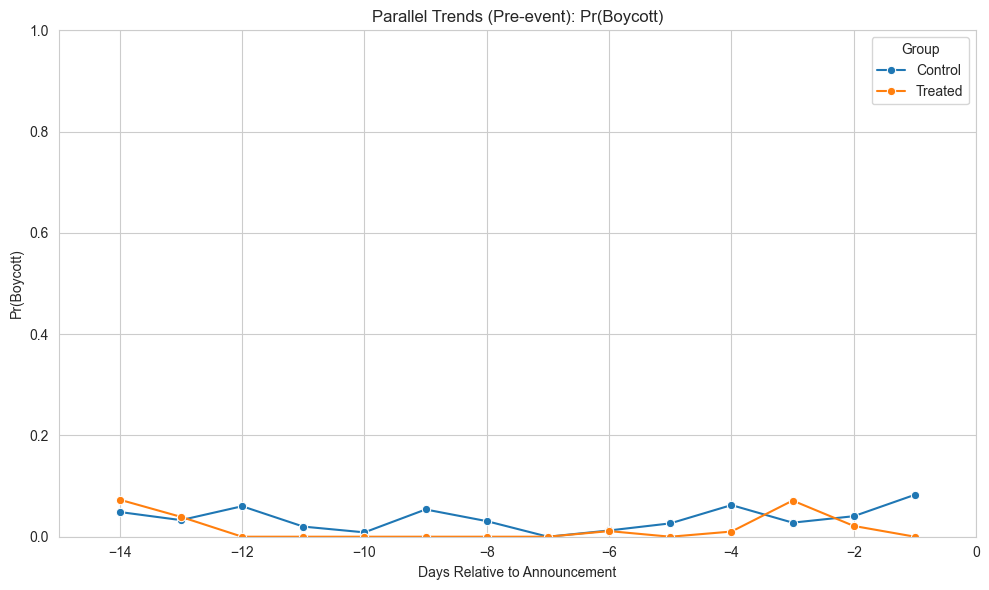

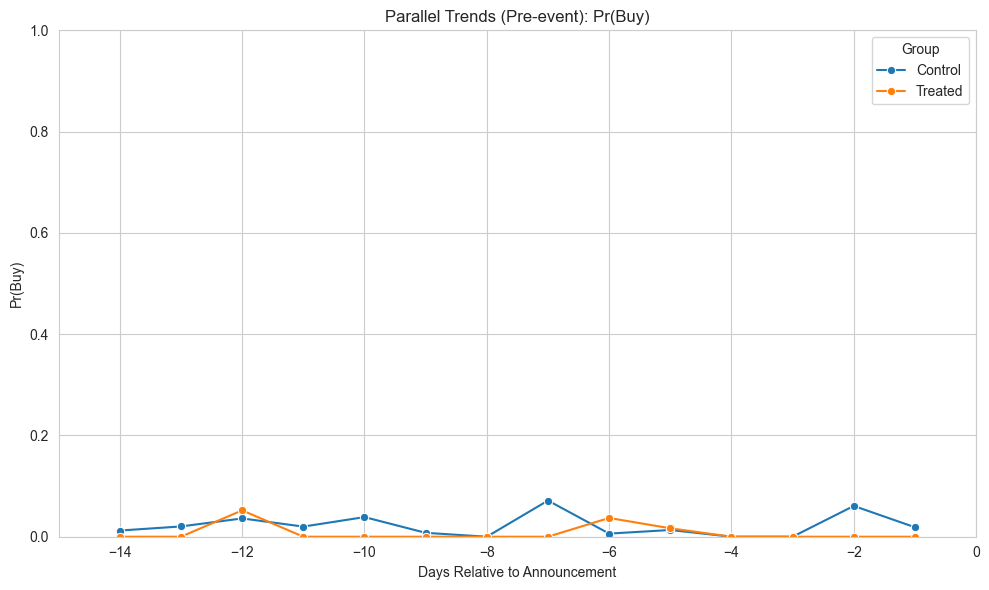

In [16]:
plot_parallel_trends(df_did, 'is_boycott', 'Pr(Boycott)', 'parallel_trends_boycott.png')
plot_parallel_trends(df_did, 'is_buy', 'Pr(Buy)', 'parallel_trends_buy.png')

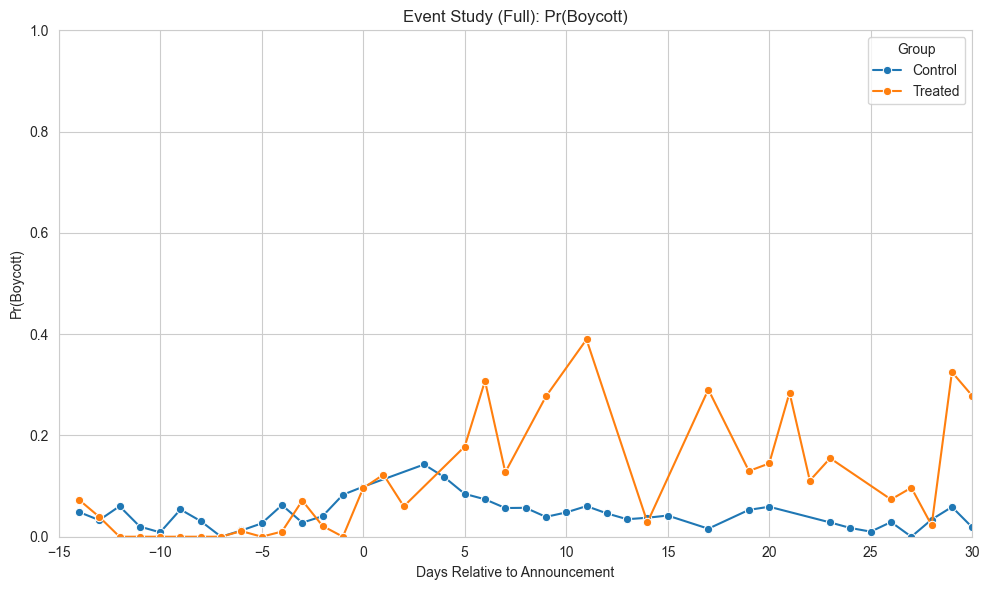

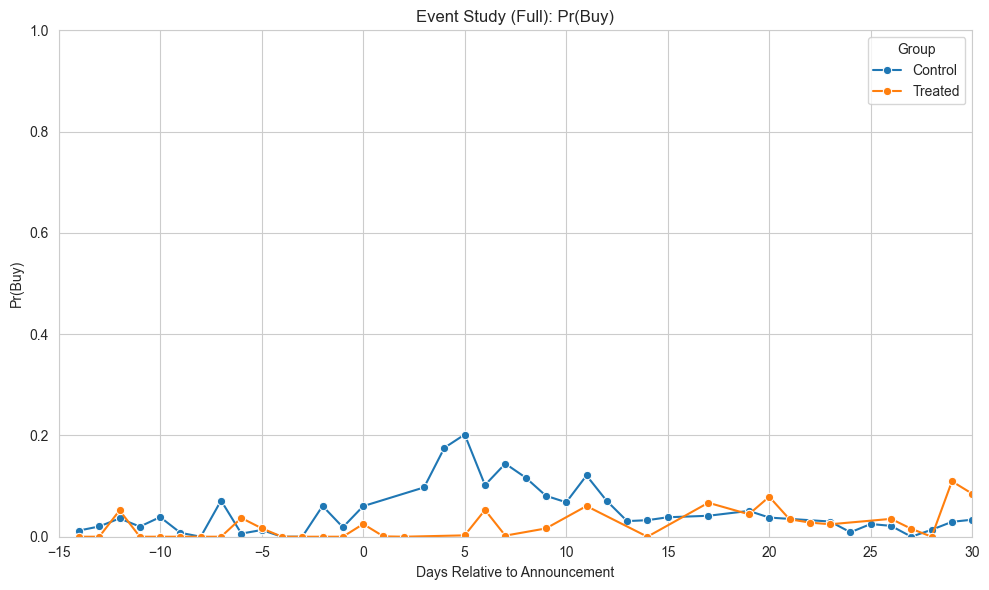

In [17]:
plot_event_study(df_did, 'is_boycott', 'Pr(Boycott)', 'parallel_trends_boycott.png')
plot_event_study(df_did, 'is_buy', 'Pr(Buy)', 'parallel_trends_buy.png')

In [18]:
for outcome, name in [
    ('is_boycott', 'Pr(Boycott)'),
    ('is_buy',     'Pr(Buy)')
]:
    rel_days = df_panel['rel_day'].unique()
    ref_day = REFERENCE_DAY if REFERENCE_DAY in rel_days else max(d for d in rel_days if d < 0)

    df_temp = df_panel.copy()
    did_terms = []
    for t in range(EVENT_WINDOW_PRE, EVENT_WINDOW_POST + 1):
        if t == ref_day:
            continue
        mask = df_temp['rel_day'] == t
        if df_temp.loc[mask, 'Treated_Company_Flag'].nunique() == 2:
            term = f"DiD_{str(t).replace('-', 'm')}"
            df_temp[term] = (mask & (df_temp['Treated_Company_Flag'] == 1)).astype(int)
            did_terms.append(term)

    rhs = [
        "1",
        "Treated_Company_Flag",
        f"C(rel_day, contr.treatment(base={ref_day}))"
    ] + did_terms
    formula = f"{outcome} ~ " + " + ".join(rhs)

    model = PanelOLS.from_formula(
        formula,
        data=df_temp,
        drop_absorbed=True,
        check_rank=False
    )
    res = model.fit(cov_type='clustered', clusters=df_temp['company_name'])

    print(f"\n### {name} ({outcome})\n")
    display(res.summary)

    coef = res.params.get('Treated_Company_Flag')
    pval = res.pvalues.get('Treated_Company_Flag')
    print(f"> At rel_day={ref_day}, Treated vs. Control gap: Coef={coef:.4f}, p-value={pval:.4f}\n")


### Pr(Boycott) (is_boycott)



/Users/diegoestuar/Desktop/CGU PhD/Research/Facebook-TextAnalytics-Project/.venv/lib/python3.12/site-packages/linearmodels/panel/results.py:89: RuntimeWarning: invalid value encountered in sqrt
  return Series(np.sqrt(np.diag(self.cov)), self._var_names, name="std_error")


Dep. Variable:,is_boycott,R-squared:,0.0663
Estimator:,PanelOLS,R-squared (Between):,0.0663
No. Observations:,33060,R-squared (Within):,0.0000
Date:,"Tue, May 13 2025",R-squared (Overall):,0.0663
Time:,15:14:44,Log-likelihood,-5098.8
Cov. Estimator:,Clustered,,
,,F-statistic:,32.558
Entities:,33060,P-value,0.0000
Avg Obs:,1.0000,Distribution:,"F(72,32987)"
Min Obs:,1.0000,,
Max Obs:,1.0000,F-statistic (robust):,-1.006e+16


> At rel_day=-1, Treated vs. Control gap: Coef=0.0444, p-value=0.0000


### Pr(Buy) (is_buy)



Dep. Variable:,is_buy,R-squared:,0.0524
Estimator:,PanelOLS,R-squared (Between):,0.0524
No. Observations:,33060,R-squared (Within):,0.0000
Date:,"Tue, May 13 2025",R-squared (Overall):,0.0524
Time:,15:14:45,Log-likelihood,1701.9
Cov. Estimator:,Clustered,,
,,F-statistic:,25.352
Entities:,33060,P-value,0.0000
Avg Obs:,1.0000,Distribution:,"F(72,32987)"
Min Obs:,1.0000,,
Max Obs:,1.0000,F-statistic (robust):,-2.38e+16


> At rel_day=-1, Treated vs. Control gap: Coef=0.0074, p-value=0.0820

